In [34]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz

In [35]:

#To achieve the desired output, we need to:
#
#1. Load the JSON data.
#
#2. Create an empty DataFrame to store the final result.
#
#3. Iterate over the 'data' list in the JSON data. For each dictionary in the 'data' list:
#   - Extract the 'code' value.
#   - Iterate over the 'history' list. For each dictionary in the 'history' list:
#     - Extract the 'start' and 'interval' values.
#     - Convert the 'start' value to a datetime.
#     - Add the 'interval' value to the 'start' datetime to get the 'end' datetime.
#     - Create a new row in the DataFrame with the 'end' datetime, the 'code' value, and the 'data' value.
#4. Pivot the DataFrame to move the 'code' values into columns.


# Load the data
with open('../data/VIC1.json') as f:
    data = json.load(f)

# Initialize an empty DataFrame
df = pd.DataFrame()

# Iterate over the 'data' list
for d in data['data']:

    start = datetime.fromisoformat(d['history']['start'].replace("Z", "+00:00"))
    # interval is a string like "5m" or "30s" or "1d"
    # add the interval to the start time to get the end time
    interval = int(d['history']['interval'][:-1])
    interval_unit = d['history']['interval'][-1]
    if interval_unit != "m":
        raise ValueError("interval unit '" + interval_unit + "' not supported")
    time = start
    # Iterate over the 'history' data list
    for h in d['history']['data']:
        time = time + timedelta(minutes=int(d['history']['interval'][:-1]))
        row = {'id': d['id'], 'network':d['network'], 'region':d['region'], 'type':d['type'], 'code': d['code'], 'time': time, 'data': h}
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

df.head(6)

,id,network,region,type,code,time,data
0,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:05:00+10:00,2995.0
1,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:10:00+10:00,3101.0
2,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:15:00+10:00,3070.0
3,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:20:00+10:00,3169.0
4,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:25:00+10:00,3113.0
5,au.nem.vic1.demand,nem,VIC1,power,demand,2024-01-06 11:30:00+10:00,3172.0


In [40]:
# Pivot the DataFrame
df_pivot = df.pivot(index='time', columns='id', values='data')
df_pivot['au.nem.vic1.fuel_tech.solar_rooftop_30min.power'] = df_pivot['au.nem.vic1.fuel_tech.solar_rooftop.power']
# Interpolate 'NaN' values in 'solar_rooftop' data 30 min intervals to 6 five-minute intervals
df_pivot['au.nem.vic1.fuel_tech.solar_rooftop.power'] = df_pivot['au.nem.vic1.fuel_tech.solar_rooftop_30min.power'].interpolate() / 6
# Smooth out the 'solar_rooftop' data over six five-minute intervals
# df_pivot['au.nem.vic1.fuel_tech.solar_rooftop_smooth.power'] = df_pivot['au.nem.vic1.fuel_tech.solar_rooftop.power'].rolling(window=6).mean()
# show rows of wind power and price
#df_pivot[['au.nem.vic1.fuel_tech.solar_utility.power', 'au.nem.vic1.fuel_tech.solar_rooftop.power', 'au.nem.vic1.fuel_tech.solar_rooftop_30min.power', 'au.nem.vic1.fuel_tech.wind.power', 'au.nem.vic1.price']].head(40)
df_pivot[(df_pivot.index.hour == 0) & (df_pivot.index.minute == 0)].head(20)



id,au.nem.vic1.demand,au.nem.vic1.fuel_tech.battery_charging.power,au.nem.vic1.fuel_tech.battery_discharging.power,au.nem.vic1.fuel_tech.coal_brown.power,au.nem.vic1.fuel_tech.exports.power,au.nem.vic1.fuel_tech.gas_ocgt.power,au.nem.vic1.fuel_tech.hydro.power,au.nem.vic1.fuel_tech.imports.power,au.nem.vic1.fuel_tech.solar_rooftop.power,au.nem.vic1.fuel_tech.solar_utility.power,au.nem.vic1.fuel_tech.wind.power,au.nem.vic1.price,au.nem.vic1.temperature,au.nem.vic1.fuel_tech.solar_rooftop_30min.power
time,,,,,,,,,,,,,,
2024-01-07 00:00:00+10:00,4846.0,1.6000,10.320,4078.0,467.4,0.0,585.5,-213.60,0.0,0.0,463.7,83.41,26.0,0.0
2024-01-08 00:00:00+10:00,4497.0,1.7000,11.270,4626.0,905.2,0.0,521.3,0.00,0.0,0.0,276.8,80.36,20.8,0.0
2024-01-09 00:00:00+10:00,4431.0,0.8188,0.931,4027.0,789.6,0.0,223.3,0.00,0.0,0.0,997.1,81.45,18.4,0.0
2024-01-10 00:00:00+10:00,4520.0,1.7000,35.780,4029.0,192.2,0.0,198.7,-154.10,0.0,0.0,332.4,98.51,18.7,0.0
2024-01-11 00:00:00+10:00,4504.0,0.3330,23.780,4440.0,1149.0,0.0,629.7,-44.81,0.0,0.0,575.4,73.35,17.7,0.0
2024-01-12 00:00:00+10:00,4589.0,0.7472,31.330,4580.0,1177.0,0.0,497.0,0.00,0.0,0.0,713.4,75.45,17.0,0.0
2024-01-13 00:00:00+10:00,5067.0,1.4750,0.000,4583.0,791.9,0.0,238.2,-177.40,0.0,0.0,904.5,77.93,21.7,0.0


In [37]:
# Load the fueltech data
# Source: https://api.opennem.org.au/fueltechs
with open('../data/fueltech.json') as f:
    fueltech = json.load(f)
# Load the fueltech color data
with open('../data/fueltech_color.json') as f:
    fueltech_color = json.load(f)
# Combine the properties
for item in fueltech:
    for color_item in fueltech_color:
        if item['code'] == color_item['code']:
            item.update(color_item)

renewables = [item['code'] for item in fueltech if item['renewable']]
print(fueltech)

[{'code': 'aggregator_vpp', 'label': 'Aggregator (VPP)', 'renewable': True, 'color': '#3379bf'}, {'code': 'aggregator_dr', 'label': 'Aggregator (Demand / Response)', 'renewable': True, 'color': '#3379bf'}, {'code': 'imports', 'label': 'Network Import', 'renewable': False, 'color': '#44146f'}, {'code': 'exports', 'label': 'Network Export', 'renewable': False, 'color': '#977ab1'}, {'code': 'interconnector', 'label': 'Interconnector', 'renewable': False, 'color': '#3379bf'}, {'code': 'battery_charging', 'label': 'Battery (Charging)', 'renewable': True, 'color': '#b056bc'}, {'code': 'battery_discharging', 'label': 'Battery (Discharging)', 'renewable': True, 'color': '#b056bc'}, {'code': 'bioenergy_biomass', 'label': 'Biomass', 'renewable': False, 'color': '#a82140'}, {'code': 'coal_black', 'label': 'Coal (Black)', 'renewable': False, 'color': '#333536'}, {'code': 'coal_brown', 'label': 'Coal (Brown)', 'renewable': False, 'color': '#97785c'}, {'code': 'distillate', 'label': 'Distillate', 'r

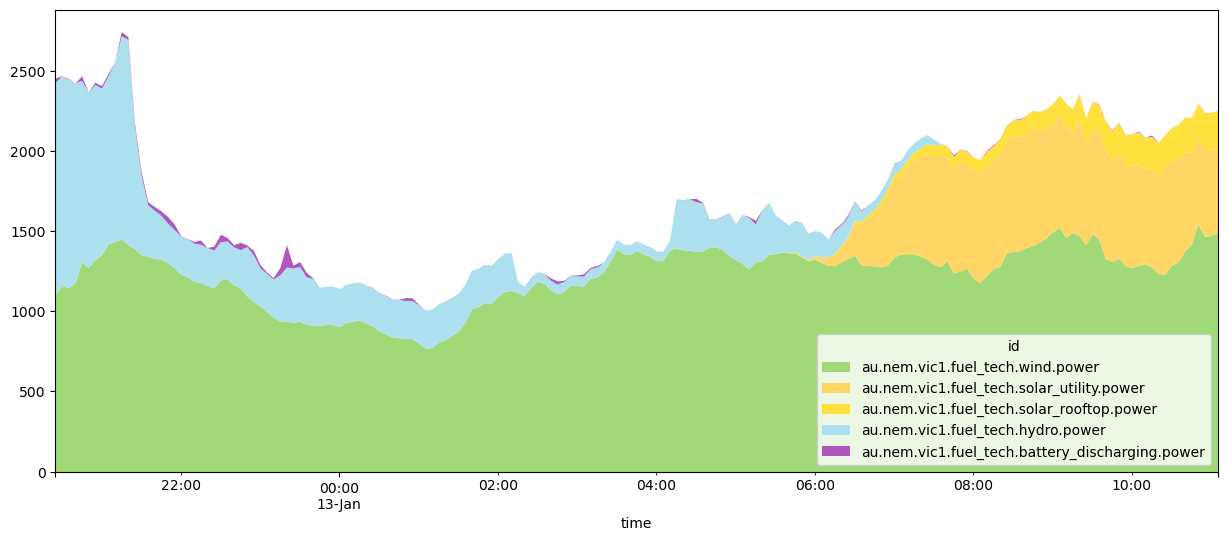

In [46]:
# Remove battery_charging from generation data
renewables = [tech for tech in renewables if tech != 'battery_charging']

renewable_fuel_tech_columns = [col for col in df_pivot.columns if any('.'+tech+'.' in col for tech in renewables)]
df_renewables = df_pivot[renewable_fuel_tech_columns]

# Plot all data
# df_renewables.plot.area(figsize=(15, 6))

# Get the current time and make it timezone-aware
now = datetime.now().replace(tzinfo=pytz.UTC)

# Convert to the desired timezone
now = now.astimezone(pytz.timezone('Australia/Melbourne'))

# Calculate the time 24 hours ago
one_day_ago = now - timedelta(days=1)

# Filter the DataFrame to include only rows where 'time' is within the last 24 hours
df_last_24_hours = df_renewables[df_renewables.index > one_day_ago]

# Create a color map from the fueltech list
color_map = {item['code']: item['color'] for item in fueltech}

# Create a list of colors for the columns in df_last_24_hours
#colors = [color_map.get(col.split('.')[-2], 'default_color') for col in df_last_24_hours.columns]

# Reverse the order of the columns so most intermittent sources are on top
df_last_24_hours = df_last_24_hours[df_last_24_hours.columns[::-1]]

# Create a list of colors for the columns in df_last_24_hours in reverse order
colors = [color_map.get(col.split('.')[-2], 'default_color') for col in df_last_24_hours.columns]


# Create a stacked area plot with edgecolor same as facecolor otherwise lines are drawn even when data is zero or missing
ax = df_last_24_hours.plot.area(figsize=(15, 6), color=colors, linewidth=0)
# Set edgecolor of patches to be the same as facecolor
for patch in ax.patches:
    patch.set_edgecolor(patch.get_facecolor())

